## Making a mixed dataset (regular batches and batches with fault events)
Here the whole process of creating batches with and without fault based on Monte Carlo simulations is shown. The resulting output is specifically made to serve as the basis for applying Machine Learning techniques for fault detection.

In [1]:
from fermfaultdetect.data import make_dataset
from fermfaultdetect.visualizations import visualize
from fermfaultdetect.utils import get_root, get_simulation_dir
import os
import ipywidgets as widgets

project_root = get_root()

# Training data set: 42
# Test data set: 24
# Validation data set: 44
seed = 42

### Choose your recipe and the number of batches

In [2]:
style = {'description_width': 'initial'}

# Name widget
name = widgets.Text(value='', description='Set name:', style=style)

# Widget for recipe
c_f = widgets.BoundedFloatText(value=500, min=100, max=600, step=10, description='Feed concentration [g/L]:', style=style)
N = widgets.BoundedFloatText(value=250, min=50, max=1000, step=10, description='Agitator speed [rpm]:', style=style)
p_HS = widgets.BoundedFloatText(value=1.01325, min=1.0, max=2, step=0.01, description='Headspace pressure [bar]:', style=style)
V0 = widgets.BoundedFloatText(value=300, min=200, max=400, step=1, description='Initial volume [L]:', style=style)

# Widgets for number of batches
n_total = widgets.BoundedIntText(value=10, min=1, max=100000, step=1, description='Total number of batches', style=style)
n_defect_steambarrier = widgets.BoundedIntText(value=0, min=0, max=600, step=1, description='Batches with defect steambarriers', style=style)
n_steam_in_feed = widgets.BoundedIntText(value=0, min=0, max=10000, step=1, description='Batches steam in feed', style=style)
n_airflow_OOC = widgets.BoundedIntText(value=0, min=0, max=10000, step=1, description='Batches with airflow out-of-calibration', style=style)
n_OUR_OOC = widgets.BoundedIntText(value=0, min=0, max=10000, step=1, description='Batches with offgas spec out-of-calibration', style=style)
n_blocked_spargers = widgets.BoundedIntText(value=0, min=0, max=10000, step=1, description='Batches with blocked spargers', style=style)

# Set name widget
print("Choose a name for this set of simulations:")
display(name)

# Display recipe widgets
print("Define recipe:")
display(c_f, N, p_HS, V0)

# Display number of batches widgets
print("Choose the total number of batches and number of fault events:")
display(n_total, n_defect_steambarrier, n_steam_in_feed, n_airflow_OOC, n_OUR_OOC, n_blocked_spargers)

Choose a name for this set of simulations:


Text(value='', description='Set name:', style=TextStyle(description_width='initial'))

Define recipe:


BoundedFloatText(value=500.0, description='Feed concentration [g/L]:', max=600.0, min=100.0, step=10.0, style=…

BoundedFloatText(value=250.0, description='Agitator speed [rpm]:', max=1000.0, min=50.0, step=10.0, style=Desc…

BoundedFloatText(value=1.01325, description='Headspace pressure [bar]:', max=2.0, min=1.0, step=0.01, style=De…

BoundedFloatText(value=300.0, description='Initial volume [L]:', max=400.0, min=200.0, step=1.0, style=Descrip…

Choose the total number of batches and number of fault events:


BoundedIntText(value=10, description='Total number of batches', max=100000, min=1, style=DescriptionStyle(desc…

BoundedIntText(value=0, description='Batches with defect steambarriers', max=600, style=DescriptionStyle(descr…

BoundedIntText(value=0, description='Batches steam in feed', max=10000, style=DescriptionStyle(description_wid…

BoundedIntText(value=0, description='Batches with airflow out-of-calibration', max=10000, style=DescriptionSty…

BoundedIntText(value=0, description='Batches with offgas spec out-of-calibration', max=10000, style=Descriptio…

BoundedIntText(value=0, description='Batches with blocked spargers', max=10000, style=DescriptionStyle(descrip…

In [3]:
# Run this cell after changing the number of batches
# Choose the number of events
set_name = name.value
n_batches = n_total.value
fault_counts = {"defect_steambarrier": n_defect_steambarrier.value, "steam_in_feed": n_steam_in_feed.value,
                "airflow_OOC": n_airflow_OOC.value, "OUR_OOC": n_OUR_OOC.value, "blocked_spargers": n_blocked_spargers.value}

### Setup for the Monte Carlo simulations

In [4]:
# Setup for the Monte Carlo simulation of the biokinetic uncertainty
bio_config = {
    "X0": (5.0, 10, "truncated_normal"), # Median, Uncertainty (%), Distribution (normal, uniform)
    "C": (28.46, 0, "constant"),
    "Y_SX": (0.3, 10, "truncated_normal"),
    "Y_SE": (0.1, 10, "truncated_normal"),
    "Y_SO": (0.6, 10, "truncated_normal"),
    "Y_SC": (0.9, 10, "truncated_normal"),
    "Y_XS_true": (1.81, 10, "truncated_normal"),
    "Y_XO_true": (0.0328, 10, "truncated_normal"),
    "m_s": (0.013, 10, "truncated_normal"),
    "m_o": (0.0003, 10, "truncated_normal")
}

# Setup for the Monte Carlo simulation of the fault events
# Dist = distribution (can be "uniform", "normal", "truncated_normal", "constant")
fault_config = {
    "defect_steambarrier": {"min_flow": 0.1, "max_flow": 0.6, "dist_flow": "truncated_normal", 
                            "min_duration": 230, "max_duration": 250, "dist_duration": "uniform",
                            "min_t_start": 0, "max_t_start": 100, "dist_t_start": "uniform"},
    "steam_in_feed": {"min_flow": 0.1, "max_flow": 0.6, "dist_flow": "truncated_normal", 
                            "min_duration": 230, "max_duration": 250, "dist_duration": "uniform",
                            "min_t_start": 0, "max_t_start": 100, "dist_t_start": "uniform"},
    "airflow_OOC": {"min_offset": 10, "max_offset": 20, "dist_flow": "binary_truncated_normal"},
    "OUR_OOC": {"min_offset": 10, "max_offset": 30, "dist_flow": "binary_truncated_normal"},
    "blocked_spargers": {"min_offset": -20, "max_offset": -50, "dist_flow": "truncated_normal",
                        "min_t_start": 0, "max_t_start": 100, "dist_t_start": "uniform",
                        "min_duration": 20, "max_duration": 30, "dist_duration": "truncated_normal"}
}

# Creating config based on defined recipe
init_config = {
    'c_f': c_f.value,
    'N': N.value/60,
    'p_HS': p_HS.value,
    'V0': V0.value
}

### Start simulating

In [5]:
output = make_dataset.generate_mixed_dataset(n_batches, init_config, bio_config, fault_counts, 
                                             fault_config, set_name, dataset_mode='Fault_training', noise=True, progress_bar=True, seed=seed)

IntProgress(value=0, bar_style='info', description='Processing:', max=10)

### Visualize dataset

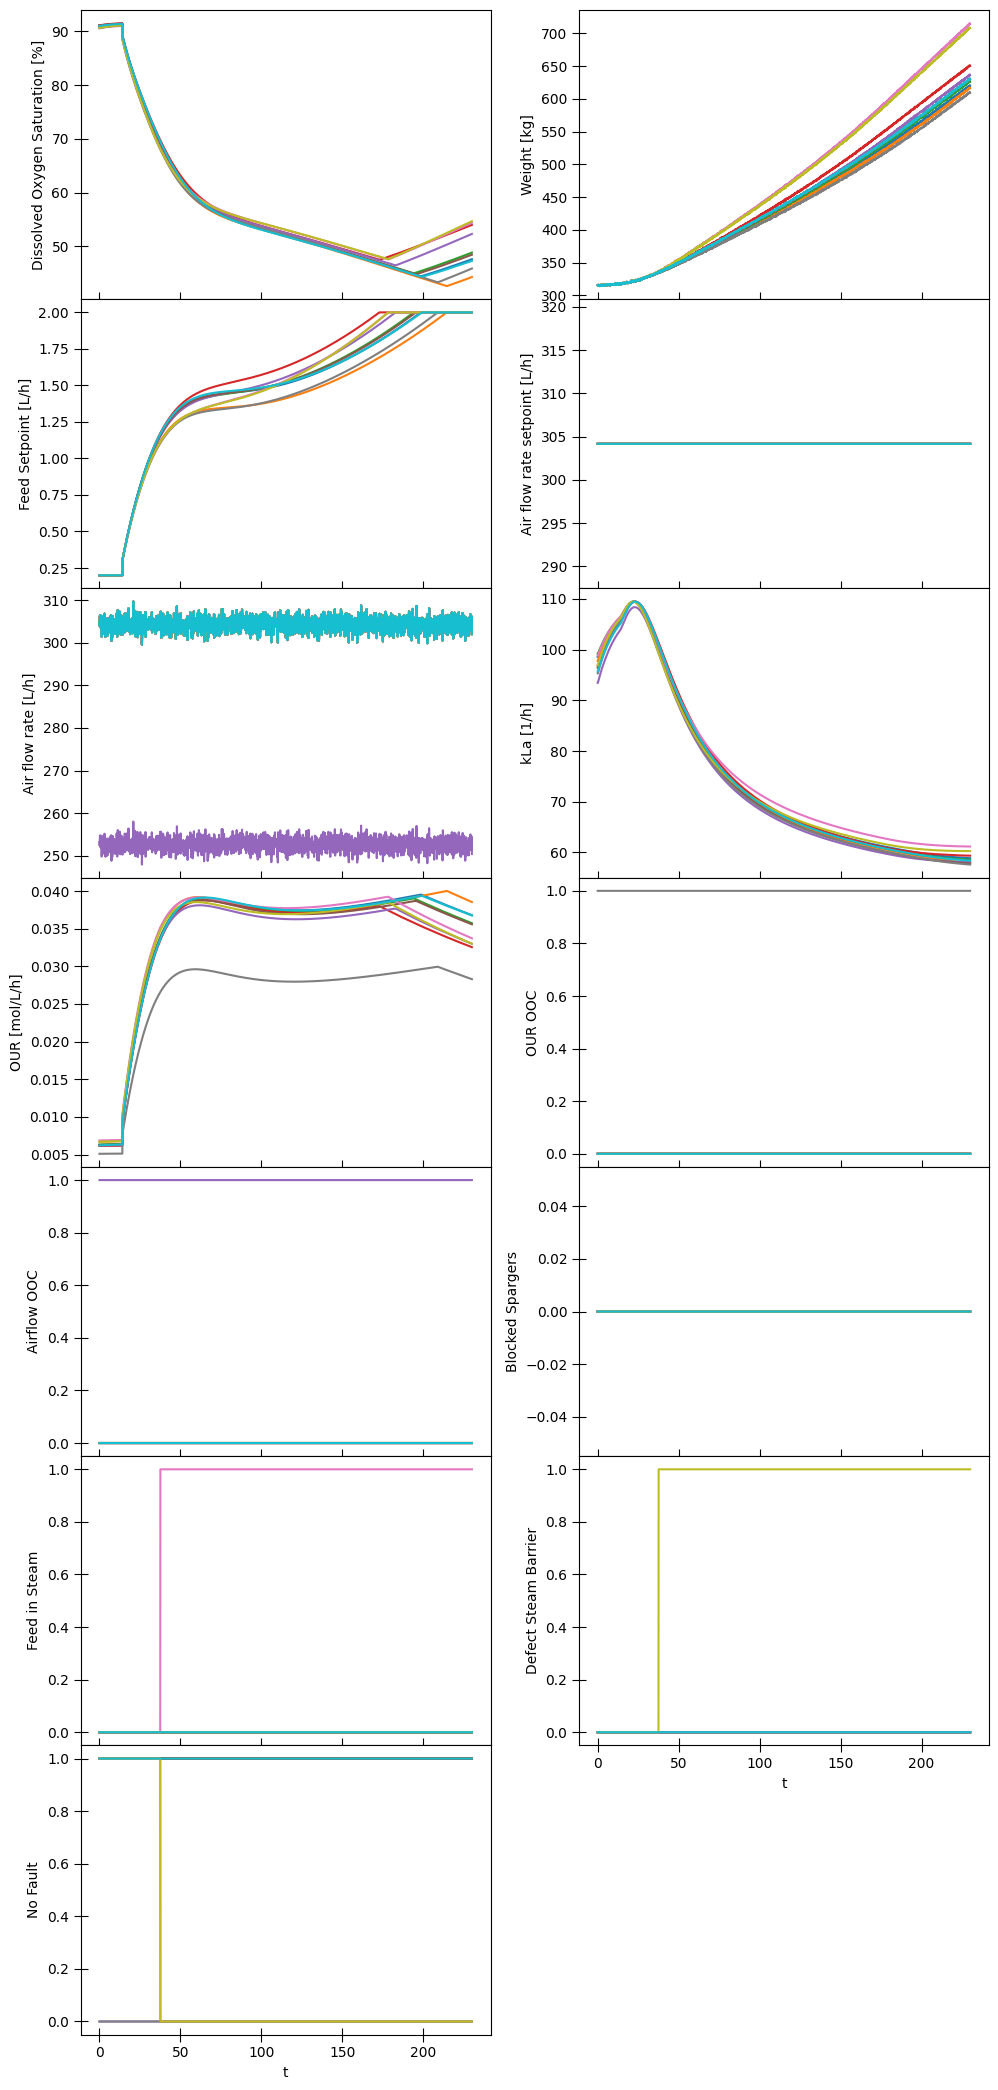

In [6]:
set_dir = os.path.join(get_simulation_dir(), set_name)
visualize.plot_batchfolder(set_dir)